<a href="https://colab.research.google.com/github/Shivstdn25/my-colab-notebooks/blob/main/Language_Detection_using_fine_tuned_XLM_Roberta_Base_Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the necessary libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=ac850cc4834224303d852c47a05f3836c7b4e39a059bc6a6b35342146cd59139
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings("ignore")
import tensorflow as tf
import tf_keras
from tf_keras.models import Model
from tf_keras.layers import Dense, Input, Dropout, Flatten
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint
from tf_keras.losses import CategoricalCrossentropy
from tf_keras.optimizers import Adam
from tf_keras.metrics import CategoricalAccuracy
from tf_keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from wordcloud import WordCloud
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")


from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

## Updating the default configuration

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)

## Loading the dataset

In [ ]:
df = pd.read_csv("Language Detection.csv")
df = df.sample(frac=1)
df.head()

,Text,Language
3442,"Ainsi, Philippe Descola dans Par-delà nature e...",French
7507,i tuoi amici mi sento molto pigro.,Italian
937,"Each connection, like the synapses in a biolog...",English
656,[291] Andrew Lih and Andrew Brown both maintai...,English
3185,não mencione isso.,Portugeese


## Feature Engineering

In [ ]:
df.shape

(10337, 2)

In [ ]:
df.Language.unique()

array(['French', 'Italian', 'English', 'Portugeese', 'Turkish', 'Arabic',
       'Sweedish', 'Hindi', 'Malayalam', 'Dutch', 'Russian', 'Kannada',
       'Tamil', 'Spanish', 'Danish', 'Greek', 'German'], dtype=object)

In [ ]:
df.Language.replace(to_replace=['Portugeese','Sweedish'],value=['Portuguese','Swedish'],inplace=True)

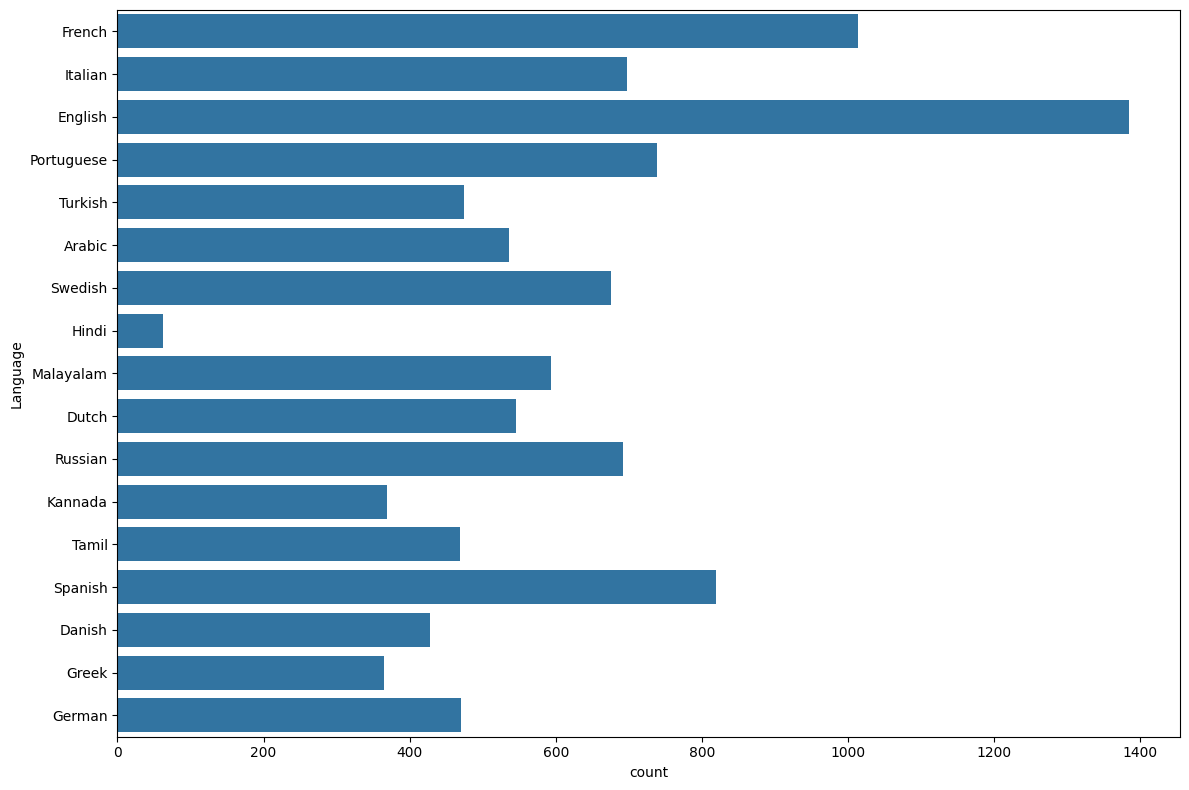

In [ ]:
sns.countplot(df.Language)
plt.tight_layout();

In [ ]:
df = df[df.Language.isin(["English","French","Dutch","Spanish","Danish","Italian","Swedish","German","Portuguese","Turkish"])]
df.shape

(7249, 2)

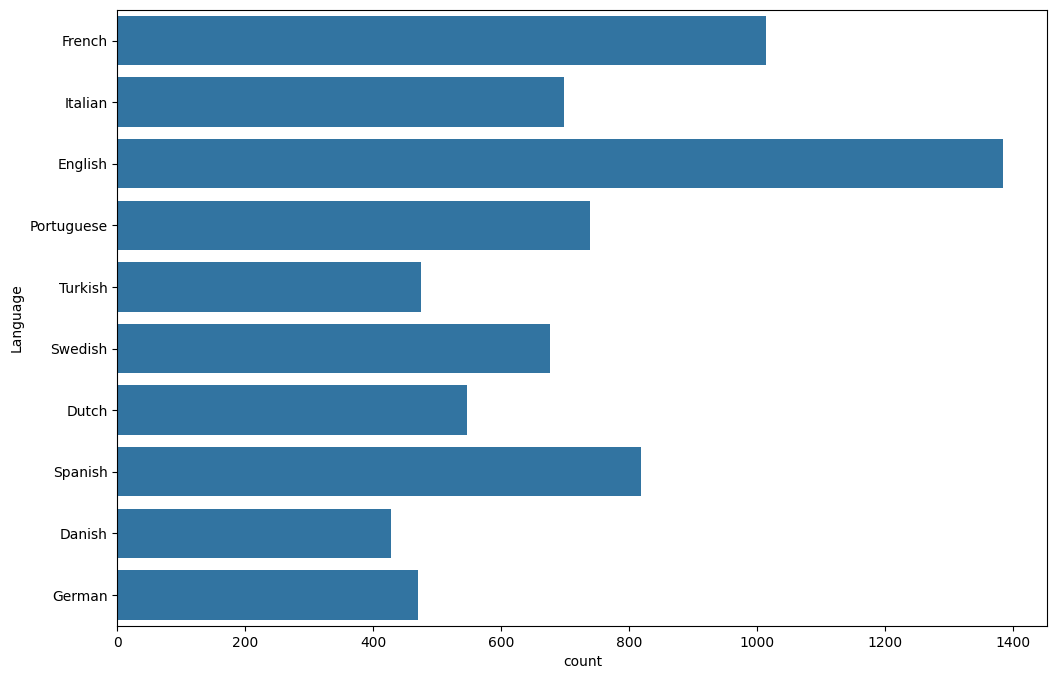

In [ ]:
sns.countplot(df.Language);

The target language classes are considerably imbalanced so they need to be accounted for later.

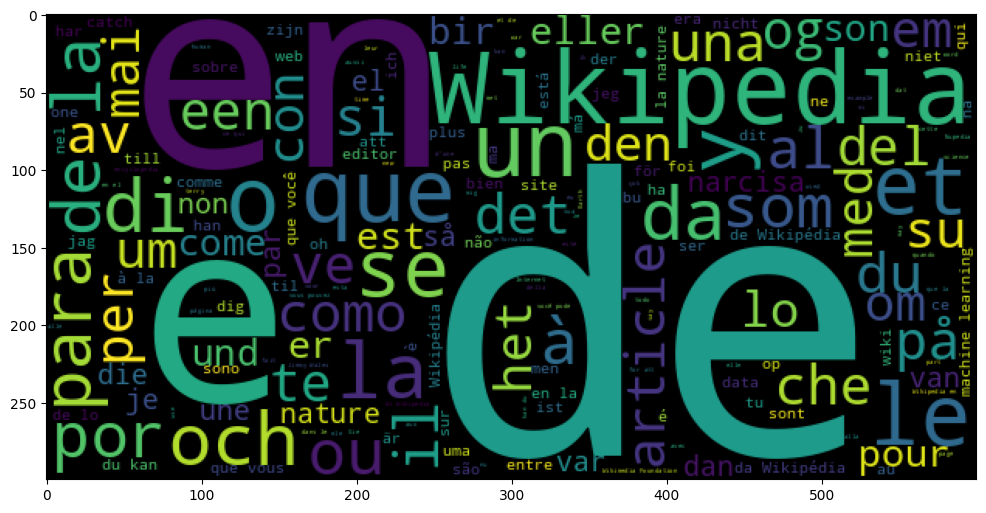

In [ ]:
wc = WordCloud(width=600,height=300,random_state=42).generate(' '.join(df.Text))
plt.imshow(wc);

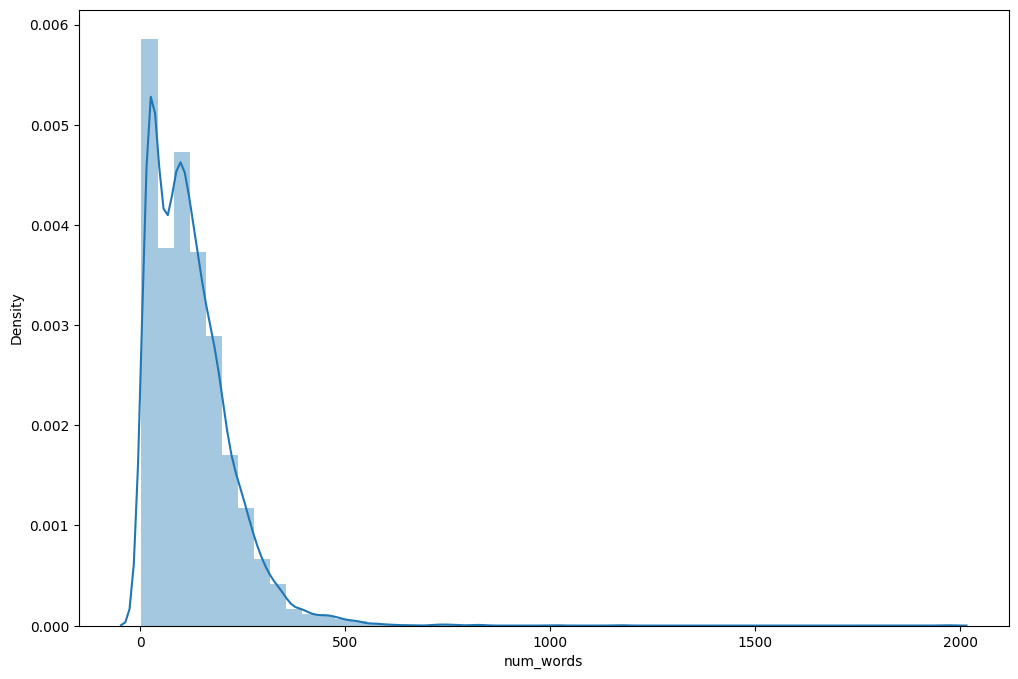

In [ ]:
df['num_words'] = df.Text.apply(len)
sns.distplot(df.num_words);

In [ ]:
df.num_words.describe()

,num_words
count,7249.000000
mean,123.570010
std,98.117023
min,3.000000
25%,48.000000
50%,106.000000
75%,173.000000
max,1965.000000


In [ ]:
max_len = 125

## Text Preprocessing

In [ ]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [ ]:
preprocessed_df = text_preprocess(df,'Text')
preprocessed_df.head()

,Text,Language,num_words
3442,ainsi philippe descola dans pardel nature et c...,French,173
7507,tuoi amici mi sento molto pigro,Italian,34
937,each connection synapses biological brain tran...,English,134
656,andrew lih andrew brown maintain editing wikip...,English,144
3185,o mencione isso,Portuguese,18


## Encoding the target label classes

In [ ]:
labels_dict = {}
for idx, lang in enumerate(preprocessed_df.Language.unique()):
    labels_dict[lang] = idx
labels_dict

{'French': 0,
 'Italian': 1,
 'English': 2,
 'Portuguese': 3,
 'Turkish': 4,
 'Swedish': 5,
 'Dutch': 6,
 'Spanish': 7,
 'Danish': 8,
 'German': 9}

In [ ]:
preprocessed_df['Label'] = preprocessed_df.Language.map(labels_dict)
preprocessed_df.head()

,Text,Language,num_words,Label
3442,ainsi philippe descola dans pardel nature et c...,French,173,0
7507,tuoi amici mi sento molto pigro,Italian,34,1
937,each connection synapses biological brain tran...,English,134,2
656,andrew lih andrew brown maintain editing wikip...,English,144,2
3185,o mencione isso,Portuguese,18,3


In [ ]:
preprocessed_df.sample(frac=1)

,Text,Language,num_words,Label
2801,o crescimento da wikipdia tem sido alimentado ...,Portuguese,257,3
6786,dine venner der er denne fantastiske kanal stu...,Danish,293,8
5204,el aprendizaje es ms que una necesidad es un f...,Spanish,127,7
953,decision tree learning uses decision tree pred...,English,212,2
28,despite wide regional variations climate latit...,English,343,2
...,...,...,...,...
46,roughly million years ago earliest known super...,English,95,2
2715,ova ferramenta virtual indica que usurios de c...,Portuguese,374,3
7754,scusandosi,Italian,11,1
4069,je ne suis pas intress,French,25,0


## Splitting the preprocessed dataset into train and test sets

In [ ]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,random_state=42,shuffle=True,stratify=preprocessed_df.Language)

## Downloading the pretrained tokenizer and xlm-roberta-base language detection model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("papluca/xlm-roberta-base-language-detection")
xlm = TFAutoModelForSequenceClassification.from_pretrained("papluca/xlm-roberta-base-language-detection",from_pt=True)

tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


## Performing text tokenization

In [ ]:
X_train = tokenizer(text=train_df.Text.tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=True)

X_test = tokenizer(text=test_df.Text.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=True)

## Fine-tuning the pretrained xlm-roberta-base language detection model

In [ ]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [ ]:
embeddings = xlm(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)
output = Dense(units=1024,activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=128,activation='relu')(output)
output = Dense(units=10,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

## Model Architecture

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 125)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 125)]                0         []                            
 )                                                                                                
                                                                                                  
 tfxlm_roberta_for_sequence  TFSequenceClassifierOutput   2780590   ['input_ids[0][0]',           
 _classification (TFXLMRobe  (loss=None, logits=(None,    28         'attention_mask[0][0]']      
 rtaForSequenceClassificati  20),                                                             

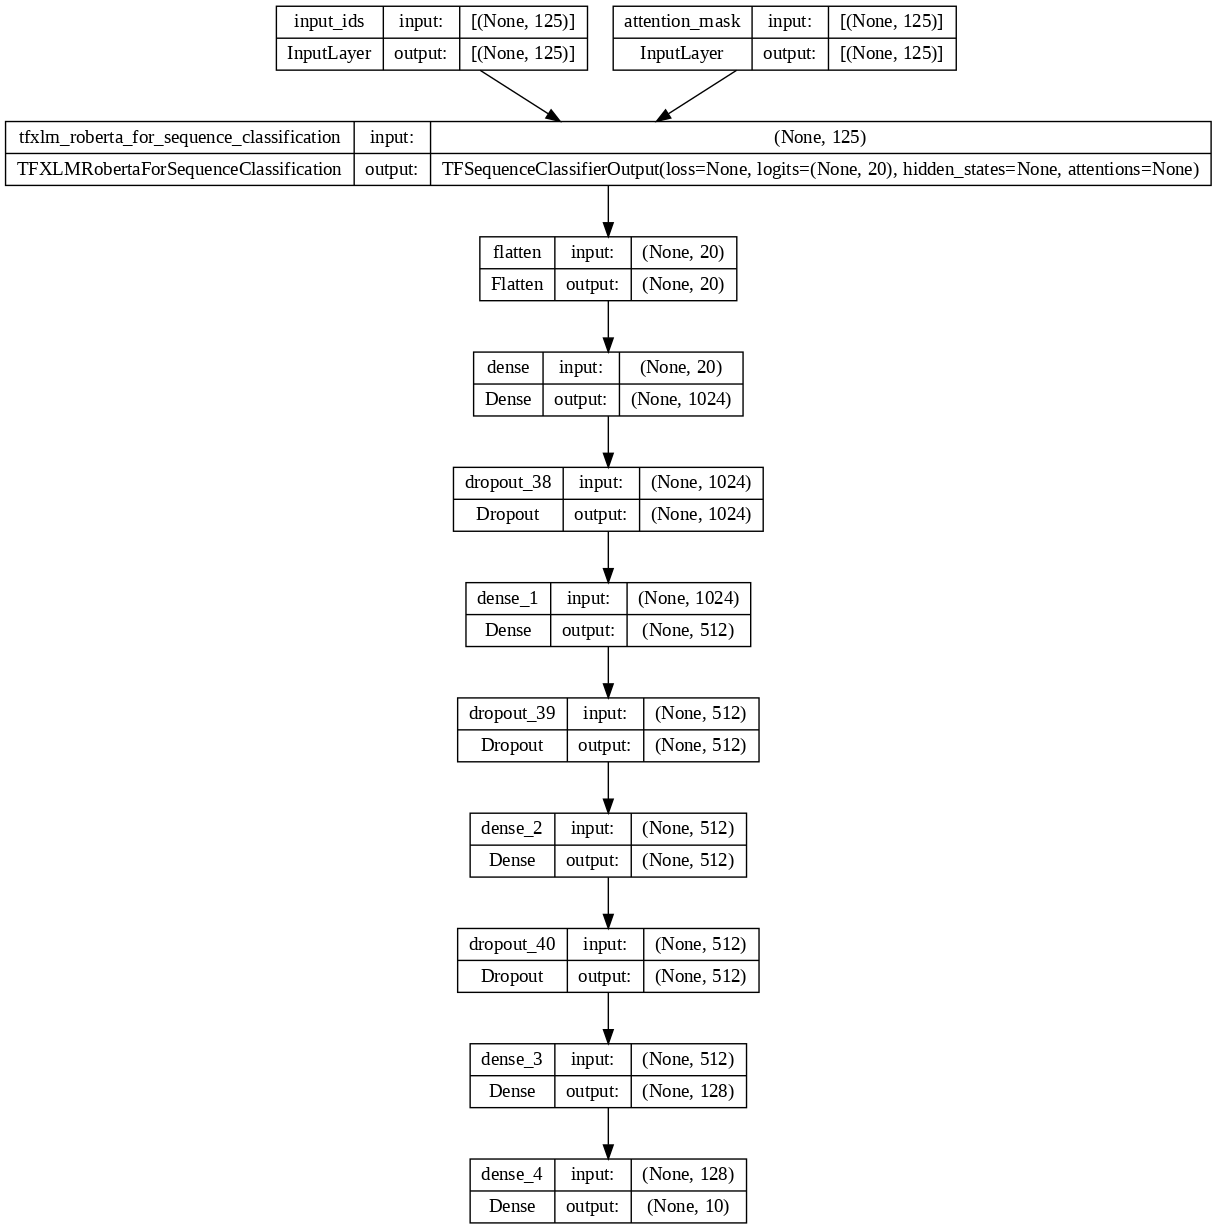

In [ ]:
plot_model(model,'model.png',show_shapes=True,dpi=100,rankdir='TB')

## Compiling the model

In [ ]:
# Create TensorFlow datasets using Keras 2
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
    to_categorical(train_df.Label)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},
    to_categorical(test_df.Label)
))

# Set up an efficient data pipeline for Keras
train_dataset = train_dataset.batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
optimizer = Adam(learning_rate=5e-5,epsilon=2e-8,clipnorm=1.0)
loss = CategoricalCrossentropy()
metrics = CategoricalAccuracy('balanced_accuracy')
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

## Training the fine-tuned XLM-Roberta-Base transformer model

In [ ]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=20,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint(filepath='checkpoint',monitor='val_balanced_accuracy',mode='max',save_best_only=True,verbose=1)

r = model.fit(train_dataset,
    epochs=25,
    callbacks=[es, mc],
    validation_data=test_dataset)

Epoch 1/50
80/80 [==============================] - ETA: 0s - loss: 1.2468 - balanced_accuracy: 0.6454
Epoch 1: val_balanced_accuracy improved from -inf to 0.98115, saving model to checkpoint
80/80 [==============================] - 263s 3s/step - loss: 1.2468 - balanced_accuracy: 0.6454 - val_loss: 0.1546 - val_balanced_accuracy: 0.9811
Epoch 2/50
80/80 [==============================] - ETA: 0s - loss: 0.2014 - balanced_accuracy: 0.9568
Epoch 2: val_balanced_accuracy improved from 0.98115 to 0.98161, saving model to checkpoint
80/80 [==============================] - 338s 4s/step - loss: 0.2014 - balanced_accuracy: 0.9568 - val_loss: 0.0868 - val_balanced_accuracy: 0.9816
Epoch 3/50
80/80 [==============================] - ETA: 0s - loss: 0.1240 - balanced_accuracy: 0.9720
Epoch 3: val_balanced_accuracy did not improve from 0.98161
80/80 [==============================] - 138s 2s/step - loss: 0.1240 - balanced_accuracy: 0.9720 - val_loss: 0.0864 - val_balanced_accuracy: 0.9789
Epoch 

## Analyzing the overall performance of trained model

In [ ]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

In [ ]:
plt.plot(r.history['balanced_accuracy'],'r',label='train balanced accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test balanced accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Balanced Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [ ]:
model.save('language_detector.h5')

## Model Evaluation

In [ ]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.Label))
print("Categorical Cross-entropy Loss:", loss)
print("Categorical Accuracy:", acc)

In [ ]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.Label,test_predictions))
print('-----------------------------')
print("Encoded Labels:")
print(labels_dict)
print('-----------------------------')
print("Classification Report:")
print(classification_report(test_df.Label,test_predictions))